<a href="https://colab.research.google.com/github/Santosh4314/Hand-gesture-recognition-model-Task-04/blob/master/Hand_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from keras.utils import plot_model
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [37]:
images=[]
labels=[]

# oop over top 10 folders
for directory in os.listdir('/content/drive/MyDrive/prodigy_data/Task-04/leapGestRecog'):
    for subdir in os.listdir(os.path.join('/content/drive/MyDrive/prodigy_data/Task-04/leapGestRecog',directory)):
#         if directory=='01':
#             labels.append(subdir)
        for image in os.listdir(os.path.join('/content/drive/MyDrive/prodigy_data/Task-04/leapGestRecog',directory, subdir)):
            img_path = os.path.join('/content/drive/MyDrive/prodigy_data/Task-04/leapGestRecog', directory, subdir, image)
            images.append(img_path)
            labels.append(subdir)


In [38]:
df = pd.DataFrame({'Image':images,'Label':labels})
df.tail()

,Image,Label
7506,/content/drive/MyDrive/prodigy_data/Task-04/le...,08_palm_moved
7507,/content/drive/MyDrive/prodigy_data/Task-04/le...,08_palm_moved
7508,/content/drive/MyDrive/prodigy_data/Task-04/le...,08_palm_moved
7509,/content/drive/MyDrive/prodigy_data/Task-04/le...,08_palm_moved
7510,/content/drive/MyDrive/prodigy_data/Task-04/le...,08_palm_moved


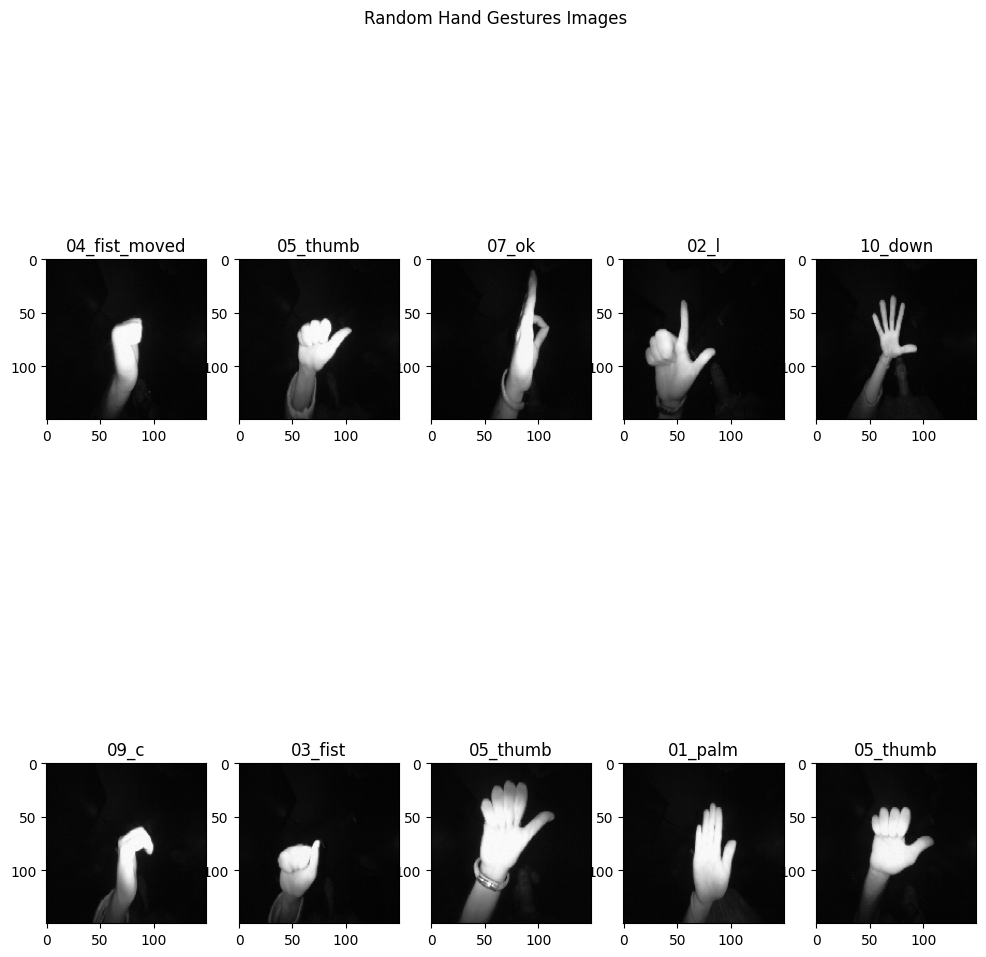

In [52]:
df_img = df['Image']
df_label = df['Label']

nrows = 2
ncols = 5
fig, axx = plt.subplots(nrows, ncols, figsize=(12, 12))
fig.suptitle("Random Hand Gestures Images")

for i in range(nrows):
    for j in range(ncols):
        n = np.random.randint(0, len(df))  # Ensure n is within valid range
        img_path = df_img.iloc[n]  # Access the image path correctly
        img = load_img(img_path, target_size=(150, 150))  # Load the image
        img = img_to_array(img)  # Convert to numpy array
        img = np.expand_dims(img, axis=0)  # Expand dimensions
        img /= 255.0  # Normalize
        label = df_label.iloc[n]  # Access label correctly

        image = np.squeeze(img)  # Reshape image for display
        axx[i, j].imshow(image)  # Display image
        axx[i, j].set_title(label)  # Set title

plt.show()
plt.close()


In [40]:
x_train,x = train_test_split(df, test_size = 0.3)
# train_x, test_x, train_y, test_y = train_test_split(images,labels,test_size=0.2)
x_valid,x_test = train_test_split(x,test_size=0.5)
x_train.info()
x_valid.info()
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5257 entries, 3229 to 4736
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   5257 non-null   object
 1   Label   5257 non-null   object
dtypes: object(2)
memory usage: 123.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1127 entries, 74 to 4890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   1127 non-null   object
 1   Label   1127 non-null   object
dtypes: object(2)
memory usage: 26.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1127 entries, 5242 to 628
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   1127 non-null   object
 1   Label   1127 non-null   object
dtypes: object(2)
memory usage: 26.4+ KB


In [41]:
#data augmentation
datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness


train_datagen = ImageDataGenerator(rescale=1.0/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)
validate_datagen = ImageDataGenerator(rescale=1.0/255)

In [42]:
b_size =1
train_generator = train_datagen.flow_from_dataframe(dataframe=x_train,x_col="Image",y_col='Label',class_mode="categorical",target_size=(150,150),batch_size=b_size,seed=2020, shuffle=True)
valid_generator = validate_datagen.flow_from_dataframe(dataframe=x_valid,x_col="Image",y_col='Label',class_mode="categorical",target_size=(150,150),batch_size=b_size,seed=2020, shuffle=False)


Found 5257 validated image filenames belonging to 10 classes.
Found 1127 validated image filenames belonging to 10 classes.


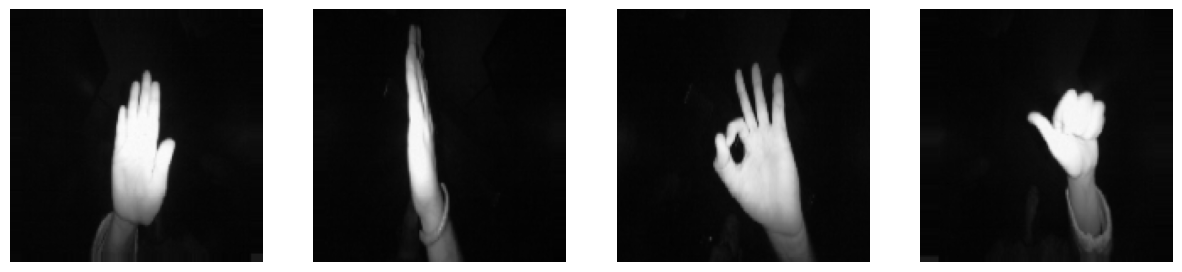

In [43]:
#plot some augmented images
fig,axx = plt.subplots(nrows=1,ncols=4, figsize=(15,15))

for i in range(4):
    image = next(train_generator)[0].astype('float64')
    image = np.squeeze(image)
    axx[i].imshow(image)
    axx[i].axis('off')

In [44]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# on top of the model we add 2 fully connected layers to flatten the 3D feature maps into 10 feature victors representing 10 differnet categories of hanf geatures
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
             optimizer = 'adam',
             metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,183,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,213,098 (4.63 MB)

 Trainable params: 1,213,098 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
#train Test data in the model
history = model.fit(train_generator,
                   steps_per_epoch=2000//b_size,
                   epochs = 20,
                   validation_data = valid_generator,
                    validation_steps=800//b_size)

model.save('handG_R.h5')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 813s 404ms/step - categorical_accuracy: 0.3308 - loss: 1.8518 - val_categorical_accuracy: 0.9225 - val_loss: 0.3364
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 458s 229ms/step - categorical_accuracy: 0.8432 - loss: 0.5162 - val_categorical_accuracy: 0.9725 - val_loss: 0.0854
Epoch 3/20
   3/2000 ━━━━━━━━━━━━━━━━━━━━ 1:47 54ms/step - categorical_accuracy: 1.0000 - loss: 0.0236

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 176s 88ms/step - categorical_accuracy: 0.9032 - loss: 0.2979 - val_categorical_accuracy: 0.9762 - val_loss: 0.0986
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 231s 116ms/step - categorical_accuracy: 0.9195 - loss: 0.2577 - val_categorical_accuracy: 0.9908 - val_loss: 0.0462
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 181s 90ms/step - categorical_accuracy: 0.9245 - loss: 0.2049 - val_categorical_accuracy: 0.9725 - val_loss: 0.0818
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 95s 47ms/step - categorical_accuracy: 0.9326 - loss: 0.1855 - val_categorical_accuracy: 0.9847 - val_loss: 0.0348
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 154s 77ms/step - categorical_accuracy: 0.9462 - loss: 0.1689 - val_categorical_accuracy: 0.9825 - val_loss: 0.0501
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 145s 72ms/step - categorical_accuracy: 0.9453 - loss: 0.1520 - val_categorical_accuracy: 0.9969 - val_loss: 0.0088
Epoch 9/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 102s 51ms/step - categorica

In [46]:
%cp -r /content/handG_R.h5 /content/drive/MyDrive

In [47]:
# display loss & accuracy
history.history


{'categorical_accuracy': [0.5230000019073486,
  0.8634999990463257,
  0.9037390351295471,
  0.9185000061988831,
  0.934499979019165,
  0.9323786497116089,
  0.9459999799728394,
  0.9440000057220459,
  0.9618138670921326,
  0.9695000052452087,
  0.9649999737739563,
  0.9657915830612183,
  0.9739999771118164,
  0.9710000157356262,
  0.9681782126426697,
  0.9779999852180481,
  0.9700000286102295,
  0.9785202741622925,
  0.9810000061988831,
  0.9815000295639038],
 'loss': [1.3582299947738647,
  0.4433801770210266,
  0.30256158113479614,
  0.25712117552757263,
  0.18856015801429749,
  0.1874435544013977,
  0.17452792823314667,
  0.15435416996479034,
  0.1347116380929947,
  0.10648151487112045,
  0.11487490683794022,
  0.10150093585252762,
  0.08634180575609207,
  0.10967020690441132,
  0.08880950510501862,
  0.07383085787296295,
  0.08830653131008148,
  0.06424544751644135,
  0.0721992552280426,
  0.07699290663003922],
 'val_categorical_accuracy': [0.9225000143051147,
  0.9724770784378052,


In [48]:
#visualize training loss & validation loss which indecates there is no overfitting
fig = go.Figure()
epochs = 20
fig.add_trace(go.Scatter(x=np.arange(0,epochs,1),
y=history.history['loss'],
mode='lines',
name=f'training loss',
marker_size=3,
line_color='blue'))
fig.add_trace(go.Scatter(x=np.arange(0, epochs, 1),
                         y=history.history['val_loss'],
                         mode='lines',
                         name=f'Validation loss',
                         line_color='grey'))
fig.update_layout(
                  title="CNN training loss",
                  xaxis_title="Epochs",
                  yaxis_title=f"CategoricalCrossentropy")

fig.update_layout({'plot_bgcolor': '#f2f8fd' ,
                   'paper_bgcolor': 'white',},
                   template='plotly_white')

In [49]:
#visualize training accuracy & validation accuracy
fig = go.Figure()
epochs = 20
fig.add_trace(go.Scatter(x=np.arange(0,epochs,1),
y=history.history['categorical_accuracy'],
mode='lines',
name=f'training accuracy',
marker_size=3,
line_color='blue'))
fig.add_trace(go.Scatter(x=np.arange(0, epochs, 1),
                         y=history.history['val_categorical_accuracy'],
                         mode='lines',
                         name=f'Validation accuracy',
                         line_color='grey'))
fig.update_layout(
                  title="CNN training accuracy",
                  xaxis_title="Epochs",
                  yaxis_title=f"CategoricalCrossentropy")

fig.update_layout({'plot_bgcolor': '#f2f8fd' ,
                   'paper_bgcolor': 'white',},
                   template='plotly_white')